In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [62]:
df = pd.read_csv('Kangaroo_train.csv')

In [18]:
df.head()

,id,veh_value,exposure,veh_body,veh_age,gender,area,dr_age,claim_ind,claim_count,claim_cost
0,3,6.43,0.241898,STNWG,1,M,A,3,0,0,0.0
1,6,4.46,0.856523,STNWG,1,M,A,3,0,0,0.0
2,20,1.70,0.417517,HBACK,1,M,A,4,0,0,0.0
3,21,0.48,0.626975,SEDAN,4,F,A,6,0,0,0.0
4,28,1.96,0.089770,HBACK,1,F,A,2,0,0,0.0


## EDA

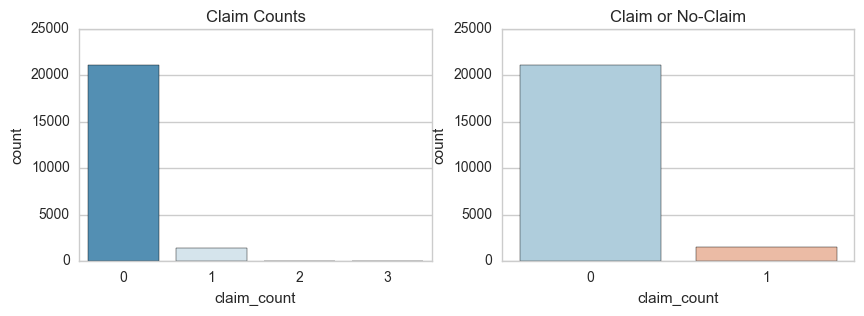

In [40]:
# Plot the Claim counts
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='claim_count',data=df, palette='RdBu_r', ax=ax1)
title = g.set_title('Claim Counts')

# Since there are very few incidences with claim count>1, we club them together with claim_count
df['claim_count'] = df['claim_count'].apply(lambda x:1 if x>0 else 0)
g = sns.countplot(x='claim_count',data=df, palette='RdBu_r', ax=ax2)
title = g.set_title('Claim or No-Claim')

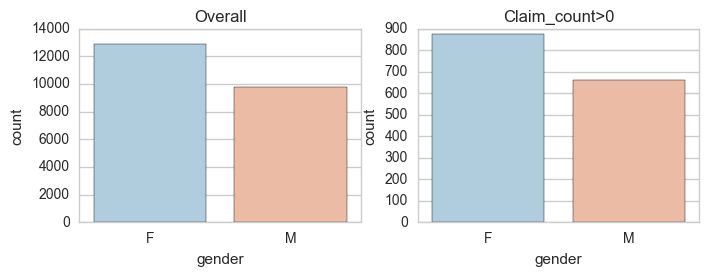

In [43]:
#Sort by sex
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8,2.5)
g = sns.countplot(x='gender',data=df.sort_values('gender'), palette='RdBu_r', ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='gender',data=df[df['claim_count']>0].sort_values('gender'), palette='RdBu_r', ax=ax2)
title = g.set_title('Claim_count>0')

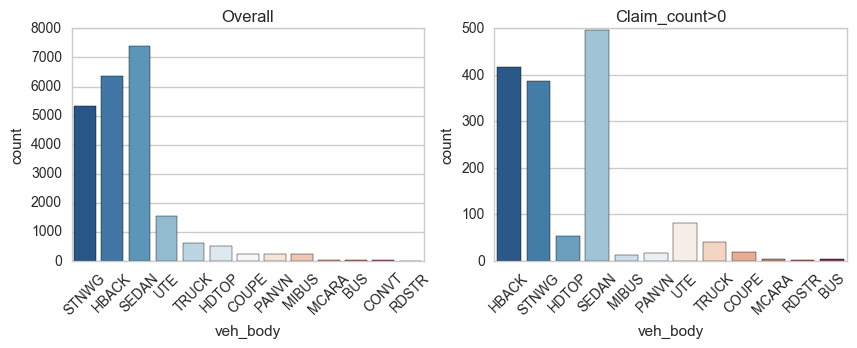

In [25]:
#Visualize Vehicle Body Type
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_body',data=df, palette='RdBu_r', ax=ax1)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Overall')
g = sns.countplot(x='veh_body',data=df[df['claim_count']>0], palette='RdBu_r', ax=ax2)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Claim_count>0')

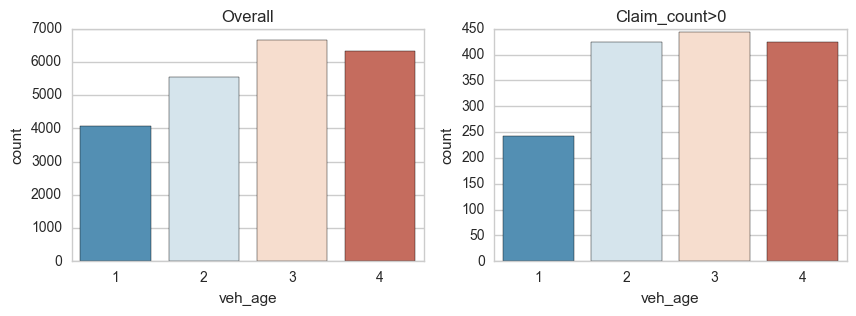

In [26]:
#Visualize Vehicle Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_age',data=df, palette='RdBu_r', ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='veh_age',data=df[df['claim_count']>0], palette='RdBu_r', ax=ax2)
title = g.set_title('Claim_count>0')

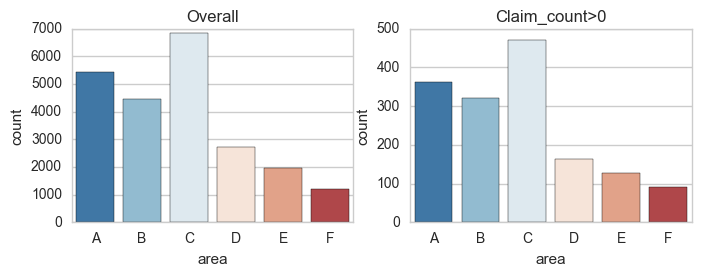

In [41]:
#Visualize Area
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8,2.5)
g = sns.countplot(x='area',data=df, palette='RdBu_r', ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='area',data=df[df['claim_count']>0], palette='RdBu_r', ax=ax2)
title = g.set_title('Claim_count>0')

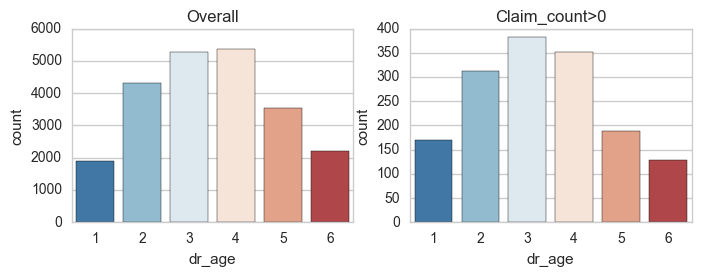

In [42]:
#Visualize Driver Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8,2.5)
g = sns.countplot(x='dr_age',data=df, palette='RdBu_r', ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='dr_age',data=df[df['claim_count']>0], palette='RdBu_r', ax=ax2)
title = g.set_title('Claim_count>0')

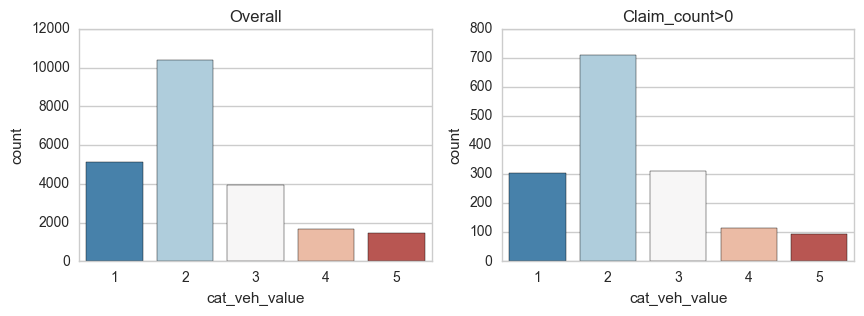

In [29]:
#Make Vehicle Value categorical
df['cat_veh_value'] = df['veh_value'].apply(lambda x:1 if x<=1 else 2 if x<=2 else 3 if x<=3 else 4 if x<=4 else 5)
#Visualize Vehicle Value
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='cat_veh_value',data=df, palette='RdBu_r', ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='cat_veh_value',data=df[df['claim_count']>0], palette='RdBu_r', ax=ax2)
title = g.set_title('Claim_count>0')

## Creating the Model

In [90]:
#Function to Prepare the data

def prep_data(df):
    #Prepare the data
    df_dummy = df[['id','veh_value','exposure','claim_count','claim_cost']].copy()
    #Make dummy variables using Pandas
    df_dummy = pd.concat([df_dummy,pd.get_dummies(df['veh_age'],drop_first=True,prefix="veh_age")],axis=1)
    df_dummy = pd.concat([df_dummy,pd.get_dummies(df['dr_age'],drop_first=True,prefix="dr_age")],axis=1)
    df_dummy = pd.concat([df_dummy,pd.get_dummies(df['veh_body'],drop_first=True)],axis=1)
    df_dummy = pd.concat([df_dummy,pd.get_dummies(df['gender'],drop_first=True)],axis=1)
    df_dummy = pd.concat([df_dummy,pd.get_dummies(df['area'],drop_first=True)],axis=1)
    #Normalize the Vehicle Value
    df_dummy['veh_value'] = df_dummy['veh_value']/df_dummy['veh_value'].max()
    
    #We are trying to predict whether there is claim or no claim
    df_dummy['claim_count'] = df_dummy['claim_count'].apply(lambda x: 1 if x>0 else 0)
    return(df_dummy)

In [91]:
df_train = pd.read_csv('Kangaroo_train.csv')
df_valid = pd.read_csv('Kangaroo_valid.csv')

#We create a separate X_train and X_test dataset because we would require the categorical variables in the original dataset later 
#X_train and X_test dataframes have only dummy variables
X_train = prep_data(df_train)
X_test = prep_data(df_valid)

#Create two additional columns for the individual probabilities of claim (prob1) and no-claim (prob0)
X_train['prob0'] = np.zeros(len(X_train))
X_train['prob1'] = np.zeros(len(X_train))

X_test['prob0'] = np.zeros(len(X_test))
X_test['prob1'] = np.zeros(len(X_test))

In [92]:
#In the first part, we use Logistic Regression to get the probabilities of claim vs no-claim
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(C=1000, class_weight='balanced')

n=10

for i in range (0,n):
    
    #Choose 3000 Negative Classes
    X_train_temp = X_train.loc[np.random.choice(X_train[X_train['claim_count']==0].index, 3000, replace = False)]
    #Choose 3000 Positive Classes
    X_train_pos = X_train.loc[np.random.choice(X_train[X_train['claim_count']==1].index, 3000, replace = True)]
    #Append the positive classes 
    X_train_temp = X_train_temp.append(X_train_pos, ignore_index=True)

    #Separate into X and Y to train the model
    y_train_temp = X_train_temp['claim_count']
    X_train_temp.drop(['id','claim_count','claim_cost','prob0','prob1'], axis=1,inplace=True)

    
    #Fit the Logistic Regression Model
    logmodel.fit(X_train_temp,y_train_temp)
    X_train[['prob0','prob1']] = X_train[['prob0','prob1']] + logmodel.predict_proba(X_train.drop(['id','claim_count','claim_cost','prob0','prob1'],axis=1))
    X_test[['prob0','prob1']] = X_test[['prob0','prob1']] + logmodel.predict_proba(X_test.drop(['id','claim_count','claim_cost','prob0','prob1'],axis=1))

#Divide the log_proba and log_probb values by 10 to get the average log probabilities
X_train['prob0']=X_train['prob0']/n
X_train['prob1']=X_train['prob1']/n

X_test['prob0']=X_test['prob0']/n
X_test['prob1']=X_test['prob1']/n
    
#Check the metrics on training and test data
logProb = 1
temp = logProb > (X_test['prob0']/X_test['prob1'])
X_test['predicted_claim_count']= [1 if (p==True) else 0 for p in temp]

#Metrics on Test set
from sklearn.metrics import classification_report
print(classification_report(X_test['claim_count'],X_test['predicted_claim_count']))
X_test.drop('predicted_claim_count',axis=1,inplace=True)

#Calculate Claim Frequency for Test Set
X_test['predicted_freq']= X_test['prob1'].divide(X_test['prob0'])
X_test['predicted_freq']= X_test['predicted_freq'].apply(lambda x: x**3.65)

             precision    recall  f1-score   support

          0       0.96      0.58      0.72     21079
          1       0.10      0.64      0.17      1550

avg / total       0.90      0.58      0.68     22629



In [93]:
#Part 2: Use Regression for predicting Claim Severity

#Train only on the subset of positive claim counts
X_train_regress = X_train[X_train['claim_count']>0].copy()
y_train_regress = np.log(X_train[X_train['claim_count']>0]['claim_cost'])

#Implement XGBoost for regression
import xgboost as xgb
num_round = 10

T_train_xgb = xgb.DMatrix(X_train_regress.drop(['id','exposure','claim_count','claim_cost','prob0','prob1'],axis=1), y_train_regress)
params = {"objective": "reg:linear"}
gbm = xgb.train(dtrain=T_train_xgb,params=params)
predictions = gbm.predict(xgb.DMatrix(X_test.drop(['id','exposure','claim_count','claim_cost','prob0','prob1','predicted_freq'],axis=1)))
X_test['predicted_claim_cost']=[np.exp(p) for p in predictions]
X_test['predicted_claim_cost']=X_test['predicted_claim_cost'].multiply(X_test['predicted_freq'])

In [96]:
veh_value_factor = {}
for veh_value in df_train['veh_value'].unique():
    m = len(df_train[(df_train['veh_value']==veh_value) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_value']==veh_value].index)
    not_m = len(df_train[(df_train['veh_value']!=veh_value) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_value']!=veh_value].index)
    veh_value_factor[veh_value]=m/not_m

veh_body_factor = {}
for veh_body in df_train['veh_body'].unique():
    m = len(df_train[(df_train['veh_body']==veh_body) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_body']==veh_body].index)
    not_m = len(df_train[(df_train['veh_body']!=veh_body) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_body']!=veh_body].index)
    veh_body_factor[veh_body]=m/not_m
    
veh_age_factor = {}
for veh_age in df_train['veh_age'].unique():
    m = len(df_train[(df_train['veh_age']==veh_age) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_age']==veh_age].index)
    not_m = len(df_train[(df_train['veh_age']!=veh_age) & (df_train['claim_count']>0)].index)/len(df_train[df_train['veh_age']!=veh_age].index)
    veh_age_factor[veh_age]=m/not_m

gender_factor = {}
for gender in df_train['gender'].unique():
    m = len(df_train[(df_train['gender']==gender) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['gender']==gender) & (df_train['claim_count']==0)].index)
    not_m = len(df_train[(df_train['gender']!=gender) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['gender']!=gender) & (df_train['claim_count']==0)].index)
    gender_factor[gender]=m/not_m
    
area_factor = {}
for area in df_train['area'].unique():
    m = len(df_train[(df_train['area']==area) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['area']==area) & (df_train['claim_count']==0)].index)
    not_m = len(df_train[(df_train['area']!=area) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['area']!=area) & (df_train['claim_count']==0)].index)
    area_factor[area]=m/not_m

dr_age_factor = {}
for dr_age in df_train['dr_age'].unique():
    m = len(df_train[(df_train['dr_age']==dr_age) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['dr_age']==dr_age) & (df_train['claim_count']==0)].index)
    not_m = len(df_train[(df_train['dr_age']!=dr_age) & (df_train['claim_count']>0)].index)/len(df_train[(df_train['dr_age']!=dr_age) & (df_train['claim_count']==0)].index)
    dr_age_factor[dr_age]=m/not_m

In [95]:
def veh_value_filter(pos):
    factor = veh_value_factor[pos[0]]
    return pos[1]**factor

def veh_body_filter(pos):
    factor = veh_body_factor[pos[0]]
    return pos[1]**factor

def veh_age_filter(pos):
    factor = veh_age_factor[pos[0]]
    return pos[1]**factor

def gender_filter(pos):
    factor = gender_factor[pos[0]]
    return pos[1]**factor

def area_filter(pos):
    factor = area_factor[pos[0]]
    return pos[1]**factor

def dr_age_filter(pos):
    factor = dr_age_factor[pos[0]]
    return pos[1]**factor

In [99]:
df_valid['predicted_claim_cost']= X_test['predicted_claim_cost']

#Use intuition to see which factors give the highest increase in the net gini

#df_valid['predicted_claim_cost'] = df_valid[['veh_value','predicted_claim_cost']].apply(veh_value_filter,axis=1)
#df_valid['predicted_claim_cost'] = df_valid[['veh_body','predicted_claim_cost']].apply(veh_body_filter,axis=1)
#df_valid['predicted_claim_cost'] = df_valid[['veh_age','predicted_claim_cost']].apply(veh_age_filter,axis=1) 
#df_valid['predicted_claim_cost'] = df_valid[['gender','predicted_claim_cost']].apply(gender_filter,axis=1) 
df_valid['predicted_claim_cost'] = df_valid[['area','predicted_claim_cost']].apply(area_filter,axis=1) 
df_valid['predicted_claim_cost'] = df_valid[['dr_age','predicted_claim_cost']].apply(dr_age_filter,axis=1) 

In [ ]:
#Write the output csv
output = df_valid[['id','claim_cost','predicted_claim_cost']]
output.to_csv('valid_predictions.csv',index=False)